In [113]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import statsmodels.api as sm
from datetime import datetime as dt
from dateutil.relativedelta import relativedelta as rd
import schedule
from sklearn.linear_model import LinearRegression
from scipy import stats
import scipy.stats
import random
from datetime import datetime, timedelta

In [114]:
#function for testing the time it takes for another function to run

from functools import wraps
from time import time

def timing(f):
    @wraps(f)
    def wrap(*args,**kw):
        tstart = time()
        result = f(*args,**kw)
        tend = time()
        print('func:%r args: [%r,%r] took: %2.4f sec' % \
              (f.__name__,args,kw,tend-tstart))
        return result
    return wrap
        
        
    

In [266]:
@timing
def get_random_option(ticker):
    stock = yf.Ticker(ticker)
    historical_data = stock.history(period="1y")
    sigma = historical_data["Close"].pct_change().std() * (252 ** 0.5)
    mu = historical_data["Close"].pct_change().mean()*252
    expirations = stock.options
    selected_expiration = random.choice(expirations)
    
    options_chain = stock.option_chain(selected_expiration)
    
    # Filter for in-the-money (ITM) options
    itm_options = [option for option in options_chain.puts.to_dict(orient="records") if option['inTheMoney']]
    
    # Ensure there are ITM options available
    if not itm_options:
        print("No in-the-money options available for the selected expiration.")
        return
    
    # Get random ITM put option from the options chain
    random_put_option = random.choice(itm_options)
    K = random_put_option['strike']
    option_price = random_put_option['lastPrice']
    S0 = stock.history(period="1d")["Close"][-1]
    maturity_date = datetime.now() + timedelta(days=30)
    T = (maturity_date - datetime.now()).days / 365.25
    return sigma, mu, S0, K, T, option_price

option_stats = get_random_option('AAPL')
option_stats

func:'get_random_option' args: [('AAPL',),{}] took: 2.2518 sec


(0.21724841697767583,
 0.3344071842227308,
 193.4199981689453,
 220.0,
 0.08213552361396304,
 33.65)

In [240]:
#Inputs
r = 0.06 # Risk-free rate taken from US treasury bonds 
#sigma = 0.2
#mu = 0.06
#seed = None
#S0 = 100 #Initial Stock Price
#K = 100  #Strike Price
#T = 1    #Time to Maturity in Years
sigma = option_stats[0]
mu = option_stats[1]
seed = None
S0 = option_stats[2] #Initial Stock Price
K = option_stats[3]  #Strike Price
T = option_stats[4]    #Time to Maturity in Years
N = 5   #Number of Time Steps
u = 1.1  #up-factor in binomial model
d = 1/u  #down-factor in binomial model
optiontype = 'P' #Choose 'C' for call & 'P' for Put
num_paths = 6
print(sigma, mu, S0, K, T)

0.21724846890354532 0.3344071952807839 193.4199981689453 205.0 0.08213552361396304


In [267]:
@timing
def gbm_stock_price(S0, mu, sigma, T, N, seed=None):
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N+1)
    W = np.random.standard_normal(size=N+1) 
    W = np.cumsum(W) * np.sqrt(dt)  # Brownian motion
    X = (r - 0.5 * sigma**2) * t + sigma * W  # GBM process
    S = S0 * np.exp(X)  # Stock price process
    S[0] = S0
    return S

In [242]:
def matrices(r, sigma, mu, seed, S0, K, T, N, u, d, optiontype, num_paths):
    payoffs = np.zeros((num_paths, N))
    X = np.zeros((num_paths, N))
    W = np.zeros((num_paths, N))
    np.random.seed(seed)
    dt = T / N
    t = np.linspace(0, T, N)
    for path in range(num_paths):
        # Generate random samples from a normal distribution
        random_samples = np.random.normal(size=N)
        
        # Scale the random samples by the square root of the time step
        scaled_samples = np.sqrt(dt) * random_samples
        
        # Cumulatively sum the scaled samples to simulate Brownian motion
        W[path,:] = np.cumsum(scaled_samples)
        X[path,:] = S0*np.exp((mu - 0.5 * sigma**2) * t + sigma * W[path,:]) 
    X[:,0] = S0
    stock_end = X[:, -1]
    for i in range(0,N):
        payoffS = np.maximum(K-X,0)
    payoffS = payoffS[:, 1:]
    value_end = np.maximum(K-stock_end,0)
    dt = T / N
    probability_matrices = []
    for j in range(N-2, -1, -1):
        probability_matrix = np.zeros((num_paths, num_paths))
        for k in range(num_paths):
            mu_conditional = np.log(X[:, j+1] / X[k, j]) / dt - 0.5 * sigma**2
            sigma_conditional = sigma * np.sqrt(dt)
            prob = scipy.stats.norm.pdf(np.log(X[:, j+1] / X[k, j]), loc=mu_conditional, scale=sigma_conditional)
            prob /= np.sum(prob)
            probability_matrix[k, :] = prob
        probability_matrices.append(probability_matrix)
    k = 0
    cont_matrix = np.zeros((num_paths,N-1))
    for j in range(N-2,-1,-1):
        for i in range(num_paths):
            cont_matrix[i][j] = np.dot(probability_matrices[k][i,:],payoffS[:,j])*np.exp(r*dt)
        k+=1
    max_value = np.maximum(cont_matrix,payoffS)
    price = sum(1/N*max_value[:,0])
    
    return price#payoffs, probability_matrices, X, cont_matrix, max_value

matrices(r, sigma, mu, seed, S0, K, T, N, u, d, optiontype, num_paths)

C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


15.194308279067588

In [270]:
sim_prices = []
real_prices = []
option_stats = []
timings = []
num_sims = 10
@timing
def sim_vs_real(num_sims):
    for i in range(num_sims):
        option_stats = get_random_option('AAPL')
        r = 0.06 # Risk-free rate taken from US treasury bonds 
        sigma = option_stats[0]
        mu = option_stats[1]
        seed = None
        S0 = option_stats[2] #Initial Stock Price
        K = option_stats[3]  #Strike Price
        T = option_stats[4]    #Time to Maturity in Years
        N = 5   #Number of Time Steps
        u = 1.1  #up-factor in binomial model
        d = 1/u  #down-factor in binomial model
        optiontype = 'P' #Choose 'C' for call & 'P' for Put
        num_paths = 6
        sim_prices.append(matrices(r, sigma, mu, seed, S0, K, T, N, u, d, optiontype, num_paths))
        real_prices.append(option_stats[5])

sim_vs_real(num_sims)

func:'get_random_option' args: [('AAPL',),{}] took: 1.9419 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


func:'get_random_option' args: [('AAPL',),{}] took: 2.1774 sec
func:'get_random_option' args: [('AAPL',),{}] took: 2.1007 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


func:'get_random_option' args: [('AAPL',),{}] took: 2.0414 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


func:'get_random_option' args: [('AAPL',),{}] took: 1.8667 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


func:'get_random_option' args: [('AAPL',),{}] took: 1.7757 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


func:'get_random_option' args: [('AAPL',),{}] took: 2.0565 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)
AAPL: No price data found, symbol may be delisted (period=1y)


func:'get_random_option' args: [('AAPL',),{}] took: 11.9221 sec
func:'get_random_option' args: [('AAPL',),{}] took: 2.0989 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


func:'get_random_option' args: [('AAPL',),{}] took: 2.0905 sec
func:'sim_vs_real' args: [(10,),{}] took: 30.0959 sec


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\1779049943.py:32: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


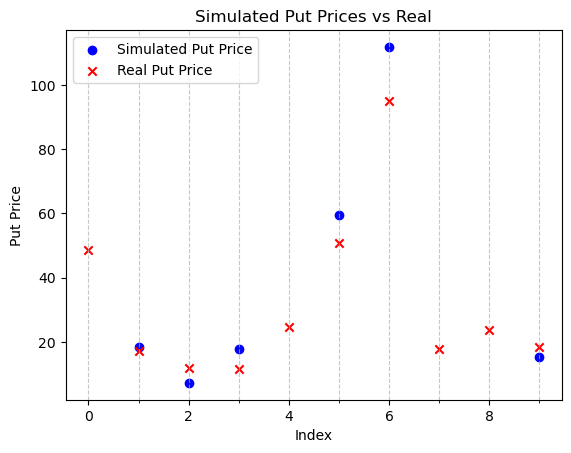

In [271]:
x_values = np.arange(len(sim_prices))

# Plot the first set of points
plt.scatter(x_values, sim_prices, label='Simulated Put Price', marker='o', color='blue')

# Plot the second set of points
plt.scatter(x_values, real_prices, label='Real Put Price', marker='x', color='red')
plt.grid(True, linestyle='--', alpha=0.7, which = 'major', axis='x')
plt.grid(True, linestyle='--', alpha=0.7, which = 'minor', axis='x')
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(1))
# Add labels and title
plt.xlabel('Index')
plt.ylabel('Put Price')
plt.title('Simulated Put Prices vs Real')

# Add a legend
plt.legend(loc = 'upper left')

# Show the plot
plt.show()

In [210]:
#Generates a brownian Motion Matrix W and a Stock Price Matrix X with each row representing 
# a stock price path starting at the initial S0 above

X = np.zeros((num_paths, N))
W = np.zeros((num_paths, N))

np.random.seed(seed)
dt = T / N
t = np.linspace(0, T, N)

for path in range(num_paths):
    # Generate random samples from a normal distribution
    random_samples = np.random.normal(size=N)
    
    # Scale the random samples by the square root of the time step
    scaled_samples = np.sqrt(dt) * random_samples
    
    # Cumulatively sum the scaled samples to simulate Brownian motion
    W[path,:] = np.cumsum(scaled_samples)
    X[path,:] = S0*np.exp((mu - 0.5 * sigma**2) * t + sigma * W[path,:])
X[:,0] = S0


In [211]:
#Visualization of stock price paths in the matrix, can be adjusted properly
X

array([[193.41999817, 188.10593091, 184.14376638, 189.58857693,
        194.89932881],
       [193.41999817, 189.07929408, 186.22390961, 185.15942026,
        181.49454565],
       [193.41999817, 205.5018126 , 197.40422417, 193.761864  ,
        192.87055669],
       [193.41999817, 204.39643292, 209.18773947, 221.75600205,
        214.51185598],
       [193.41999817, 198.89740854, 202.09466101, 208.4718093 ,
        206.61987234],
       [193.41999817, 194.37351572, 195.09909903, 186.10729368,
        193.71177495]])

In [212]:
stock_end = X[:, -1]
stock_end

array([194.89932881, 181.49454565, 192.87055669, 214.51185598,
       206.61987234, 193.71177495])

In [213]:
#determines the payoff at all times except the first time, this may have to be adjusted
# to include the first time as well in case the strike price changes
for i in range(0,N):
    payoffS = np.maximum(K-X,0)
payoffS = payoffS[:, 1:]
payoffS

array([[16.89406909, 20.85623362, 15.41142307, 10.10067119],
       [15.92070592, 18.77609039, 19.84057974, 23.50545435],
       [ 0.        ,  7.59577583, 11.238136  , 12.12944331],
       [ 0.60356708,  0.        ,  0.        ,  0.        ],
       [ 6.10259146,  2.90533899,  0.        ,  0.        ],
       [10.62648428,  9.90090097, 18.89270632, 11.28822505]])

In [214]:
value_end = np.maximum(K-stock_end,0)
value_end

array([10.10067119, 23.50545435, 12.12944331,  0.        ,  0.        ,
       11.28822505])

In [215]:


# Calculate time step
dt = T / N

# Initialize a list to store matrices for each time step
probability_matrices = []

# Calculate conditional probabilities for each time step
for j in range(N-2, -1, -1):
    probability_matrix = np.zeros((num_paths, num_paths))

    for k in range(num_paths):
        # Calculate the conditional probability using the log-normal distribution
        mu_conditional = np.log(X[:, j+1] / X[k, j]) / dt - 0.5 * sigma**2
        sigma_conditional = sigma * np.sqrt(dt)

        # Calculate the probability using the log-normal distribution formula
        prob = scipy.stats.norm.pdf(np.log(X[:, j+1] / X[k, j]), loc=mu_conditional, scale=sigma_conditional)

        # Normalize the probabilities to sum to 1
        prob /= np.sum(prob)

        # Store the probability in the matrix
        probability_matrix[k, :] = prob

    # Append the probability matrix for the current time step to the list
    probability_matrices.append(probability_matrix)

# Now, probability_matrices[j] represents the matrix of probabilities for time step j


C:\Users\stefa\AppData\Local\Temp\ipykernel_45956\179497120.py:20: RuntimeWarning: invalid value encountered in divide
  prob /= np.sum(prob)


In [216]:
payoffS

array([[16.89406909, 20.85623362, 15.41142307, 10.10067119],
       [15.92070592, 18.77609039, 19.84057974, 23.50545435],
       [ 0.        ,  7.59577583, 11.238136  , 12.12944331],
       [ 0.60356708,  0.        ,  0.        ,  0.        ],
       [ 6.10259146,  2.90533899,  0.        ,  0.        ],
       [10.62648428,  9.90090097, 18.89270632, 11.28822505]])

In [217]:
#Organized such that the first row of any matrix is the transition probabilities from the top node,
# to all nodes in the next time step, and then goes down the column of nodes repeating process for each row
#matrix 0 in list corresponds to time step J-1
probability_matrices

[array([[0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        [3.18980406e-30, 0.00000000e+00, 1.89573106e-25, 0.00000000e+00,
         0.00000000e+00, 1.00000000e+00],
        [           nan,            nan,            nan,            nan,
                    nan,            nan],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         1.00000000e+00, 0.00000000e+00],
        [           nan,            nan,            nan,            nan,
                    nan,            nan]]),
 array([[0.00000000e+000, 1.00000000e+000, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 2.88681902e-079],
        [1.27796123e-307, 2.26877495e-037, 0.00000000e+000,
         0.00000000e+000, 0.00000000e+000, 1.00000000e+000],
        [            nan,             nan,             nan,
      

In [218]:
print(N)

5


In [219]:
#multiplies the first through third row of each matrix by payoff of the corresponding time 
#ex: in matrix 1, the first row will be multiplied by the last row of the payoff matrix
#these will then be added up and put in the top right of the continuation matrix (2,2), 
# this is based on how I calculated the probabilites earlier with matrix 1 corresponding to the probabilities for time j to j+1

k = 0
cont_matrix = np.zeros((num_paths,N-1))
for j in range(N-2,-1,-1):
    for i in range(num_paths):
        cont_matrix[i][j] = np.dot(probability_matrices[k][i,:],payoffS[:,j])*np.exp(r*dt)
        print(cont_matrix[i][j], 'k=', k, "i=", i, 'j=', j)
    k+=1

12.141404303571488 k= 0 i= 0 j= 3
nan k= 0 i= 1 j= 3
11.29935651093563 k= 0 i= 2 j= 3
nan k= 0 i= 3 j= 3
0.0 k= 0 i= 4 j= 3
nan k= 0 i= 5 j= 3
19.860144778759462 k= 1 i= 0 j= 2
18.911336645711064 k= 1 i= 1 j= 2
nan k= 1 i= 2 j= 2
0.0 k= 1 i= 3 j= 2
nan k= 1 i= 4 j= 2
11.24921806679897 k= 1 i= 5 j= 2
18.794605725850317 k= 2 i= 0 j= 1
18.794605725850317 k= 2 i= 1 j= 1
2.9082039746991715 k= 2 i= 2 j= 1
2.9082039759552285 k= 2 i= 3 j= 1
7.603266113086059 k= 2 i= 4 j= 1
9.910664372070219 k= 2 i= 5 j= 1
10.636963183269039 k= 3 i= 0 j= 0
10.636963183269039 k= 3 i= 1 j= 0
10.636963183269039 k= 3 i= 2 j= 0
10.636963183269039 k= 3 i= 3 j= 0
10.636963183269039 k= 3 i= 4 j= 0
10.636963183269039 k= 3 i= 5 j= 0


In [220]:
cont_matrix

array([[10.63696318, 18.79460573, 19.86014478, 12.1414043 ],
       [10.63696318, 18.79460573, 18.91133665,         nan],
       [10.63696318,  2.90820397,         nan, 11.29935651],
       [10.63696318,  2.90820398,  0.        ,         nan],
       [10.63696318,  7.60326611,         nan,  0.        ],
       [10.63696318,  9.91066437, 11.24921807,         nan]])

In [221]:
#take max of the continuation value and current payoff (missing e^-rdt factor)
max_value = np.maximum(cont_matrix,payoffS)
max_value

array([[16.89406909, 20.85623362, 19.86014478, 12.1414043 ],
       [15.92070592, 18.79460573, 19.84057974,         nan],
       [10.63696318,  7.59577583,         nan, 12.12944331],
       [10.63696318,  2.90820398,  0.        ,         nan],
       [10.63696318,  7.60326611,         nan,  0.        ],
       [10.63696318,  9.91066437, 18.89270632,         nan]])

In [225]:
#after the above process which goes backwards through the paths, we should have a final price value by discounting the expectations at time 1 I believe.

price = sum(1/N*max_value[:,0])
price 

15.072525548994872

In [226]:
print(price, " vs ", option_stats[5])

15.072525548994872  vs  11.68
